In [1]:
#shows the number of threads available for JULIA. 
Threads.nthreads()

1

### Load packages for for plotting and the Differential Equation solver

In [2]:
using Distributed
@everywhere using MAT
@everywhere using DifferentialEquations, BenchmarkTools, ProgressLogging
@everywhere using Plots; gr()
@everywhere using JLD2

### RADI modules

In [3]:
include("modules/gsw_rho.jl")
include("modules/CO2System.jl")
include("modules/React.jl")
include("modules/Equilibrate.jl")
include("modules/Params.jl");

### Functions running inside the ODE Solver

In [4]:
"diffuse solute from bottom waters to porewaters"
function diffuse_SWI(
    then_z1p::Float64,
    then_z::Float64,
    then_w::Float64,
    D_var::Float64,
    TR::Float64,
    )
    return D_var[1] * (2*then_z1p - 2*then_z + TR *(then_w - then_z)) / (z_res^2)
end

"Calculate advection rate for a solute."
function advectsolute(
    then_z1p::Float64,
    then_z1m::Float64,
    u_z::Float64,
    D_var::Float64,
    DFF::Float64,
)
    return -(u_z - D_var * DFF) * (then_z1p - then_z1m)/(2.0z_res)
end  # function advect

"Calculate advection rate at SWI for a solute."
function advectsolute_SWI(
    u_z::Float64,
    then_z::Float64,
    then_w::Float64,
    D_var::Float64,
    DFF::Float64,
    TR::Float64,
)
    return -(u_z - D_var * DFF) * -1 * TR * (then_w - then_z) / (2.0 * z_res)
end

"Calculate irrigation rate of a solute."
function irrigate(then_z::Float64, above::Float64, alpha_z::Float64)
    return alpha_z*(above - then_z)
end  # function irrigate

"diffuse solid from bottom waters to porewaters"
function diffuseSolid_SWI(
    then_z1p::Float64,
    then_z::Float64,
    F::Float64, #flux
    D_bio::Float64,
    phiS::Float64,
    w::Float64,
    )
    return D_bio * (2*then_z1p - 2*then_z + 2*z_res * (F - phiS *w * then_z) / (D_bio * phiS)) / (z_res^2)
end

"Calculate advection rate for a solid from bottom waters to porewaters"
function advectsolid_SWI(
    then_z::Float64,
    then_z1p::Float64,
    F::Float64,
    D_bio::Float64,
    APPW::Float64,
    sigma1m::Float64,
    sigma::Float64,
    sigma1p::Float64,
    phiS::Float64,
    w::Float64,
)
    return -APPW*(sigma1m*then_z1p + 2*sigma*then_z - 
                sigma1p*(then_z1p+2*z_res/D_bio*(F/phiS-w*then_z)))/(2*z_res)
end  # function advectsolid

"Calculate diffusion rate of a solute or solid."
function diffuse(
    then_z1m::Float64,
    then_z::Float64,
    then_z1p::Float64,
    D_var::Float64,
)
    return (then_z1p - 2.0then_z + then_z1m) * D_var / (z_res^2)
end  # function diffuse


"Calculate pore-water advection rate for a solid."
function advectsolid(
    then_z::Float64,
    then_z1p::Float64,
    then_z1m::Float64,
    APPW_z::Float64,
    sigma_z::Float64,
    sigma1p_z::Float64,
    sigma1m_z::Float64,
)
    return -APPW_z*(sigma1m_z*then_z1p + 2.0sigma_z*then_z -
        sigma1p_z*then_z1m)/(2.0z_res)
end  # function advectsolid

"bottom boundary condition for diffusion"
function diffuse_BBC(
        then_z::Float64,
        then_z1m::Float64,
        D_var::Float64,)
    return D_var * 2 * ((then_z1m - then_z) / (z_res^2))
end

"Calculate bottom boundary condition advection rate for a solute."
function advectsolid_BBC(
    then_z::Float64,
    then_z1m::Float64,
    APPW_z::Float64,
    sigma_z::Float64,
    )
    return -APPW_z * (-sigma_z * then_z1m + sigma_z * then_z)/ z_res
end

function input_P(omegaCa, T)
    P = (0.9012882388755719 + 0.01814331*T - log(omegaCa)) / 0.00016455
    return P
end

function input_omegaCa(P, T)
    omegaCa = exp(0.9012882388755719 + 0.01814331*T - 0.00016455*P)
    return omegaCa
end


"Function to calculate the DBL thickness based on the current speed, following: Sulpis, O., Boudreau, B. P., Mucci, A., Jenkins, C., Trossman, D. S., Arbic, B. K., & Key, R. M. (2018). Current CaCO3 dissolution at the seafloor caused by anthropogenic CO2. Proceedings of the National Academy of Sciences, 115(46), 11700-11705."
function DBL(U, T; constant_DBL=false, user_DBL=nothing)
    # temperature dependent friction velocity
    u_star = 0.00136 - 2.19598542e-5*T + 2.35862843e-2 * U
    # Kinematic viscosity 
    nu = 1.747567451381780806e-6 - 3.23886387e-8*T

    # Helper function for diffusion and Schmidt number calculations
    function calc_diffusion_and_schmidt(param_func)
        D = param_func(T) / (60 * 60 * 24 * 365.25)
        Sc = nu / D
        beta = 0.0417 * u_star * Sc^(-2/3)
        return D / beta
    end

    # List of parameter functions
    param_funcs = [Params.D_dO2, Params.D_dtCO2, Params.D_dtNO3, Params.D_dtSO4, Params.D_dtPO4, Params.D_dtNH4, Params.D_dtH2S, Params.D_dMn, Params.D_dFe, Params.D_dCH4, Params.D_dHCO3, Params.D_dCa]

    if constant_DBL
        # Apply the user-provided DBL value to all species
        return fill(user_DBL, length(param_funcs))
    else
        # Apply the helper function to each parameter function
        return [calc_diffusion_and_schmidt(func) for func in param_funcs]
    end
end


"apparent bulk sediment diffusivity, from: McGinnis, D. F., Sommer, S., Lorke, A., Glud, R. N., & Linke, P. (2014). Quantifying tidally driven benthic oxygen exchange across permeable sediments: An aquatic eddy correlation study. Journal of Geophysical Research: Oceans, 119(10), 6918-6932."
function Ksed(U, T, permeability)
    u_star=0.00136 - 2.19598542e-5*T + 2.35862843e-2 * U #mm/s, from: Sulpis, O., Boudreau, B. P., Mucci, A., Jenkins, C., Trossman, D. S., Arbic, B. K., & Key, R. M. (2018). Current CaCO3 dissolution at the seafloor caused by anthropogenic CO2. Proceedings of the National Academy of Sciences, 115(46), 11700-11705.
    if permeability >= 1e-12 # Threshold value identified in [Huettel et al., 2014]
        alpha = 1.0
    else
        alpha = 0.0
    end
    von_k = 0.4
    # Helper to calculate Temperature-Dependent diffusion, accounting for tortuosity 
    function diff_tort(param_func)
            D = param_func(T) / (60 * 60 * 24 * 365.25)
        return D*exp(alpha*von_k*(u_star*1000))*60*60*24*365.25
    end
    
    param_funcs = [Params.D_dO2, Params.D_dtCO2, Params.D_dtNO3, Params.D_dtSO4, Params.D_dtPO4, Params.D_dtNH4, Params.D_dtH2S, Params.D_dMn, Params.D_dFe, Params.D_dCH4, Params.D_dHCO3, Params.D_dCa]
    
    return [diff_tort(func) for func in param_funcs]
end

function rates_wD(kfast, kslow, phiS_phi, dSi_inp, TB, KF, KSO4, K1, K2, KNH3, KP1, KP2, KP3, KSi, KB, Kw, TF, KH2S, KCa, KAr, RC, RN, RP, prev_dO2, prev_dtCO2, prev_dtNO3, prev_dtSO4, prev_dtPO4, prev_dtNH4, prev_dtH2S, prev_dFeII, prev_dMnII, prev_dCH4, prev_dalk, prev_dCa, prev_pfoc, prev_psoc, prev_pFeOH3, prev_pMnO2, prev_pcalcite, prev_paragonite, prev_dH)
    # Use prev_H instead of inp[19] for the previous timestep value
    alk_borate = Equilibrate.alk_borate(prev_dH, TB, KB)
    alk_noncarbonate = (
        Equilibrate.alk_ammonia(prev_dH, prev_dtNH4, KNH3) +
        alk_borate +
        Equilibrate.alk_fluoride(prev_dH, TF, KF) +
        Equilibrate.alk_phosphate(prev_dH, prev_dtPO4, KP1, KP2, KP3) +
        Equilibrate.alk_silicate(prev_dH, dSi_inp, KSi) +
        Equilibrate.alk_sulfate(prev_dH, prev_dtSO4, KSO4) +
        Equilibrate.alk_sulfide(prev_dH, prev_dtH2S, KH2S) +
        Equilibrate.alk_water(prev_dH, Kw)
    )
    alk_carbonate = Equilibrate.alk_carbonate(prev_dH, prev_dtCO2, K1, K2)
    alk_residual = prev_dalk - (alk_carbonate + alk_noncarbonate)
    dalk_dh = Equilibrate.dalk_dh(prev_dH, prev_dtCO2, alk_borate, K1, K2, KB, Kw)
    dH_delta = alk_residual / dalk_dh
    H = prev_dH + dH_delta

    # End with carbonate ion concentration
    dCO3 = prev_dtCO2 * K1 * K2 / (K1 * K2 + K1 * H + H^2)

    # Reactions
        (
            rate_dO2,
            rate_dtCO2,
            rate_dtNO3,
            rate_dtSO4,
            rate_dtPO4,
            rate_dtNH4,
            rate_dtH2S,
            rate_dFeII,
            rate_dMnII,
            rate_dCH4,
            rate_dalk,
            rate_dCa,
            rate_pfoc,
            rate_psoc,
            rate_pFeOH3,
            rate_pMnO2,
            rate_pcalcite,
            rate_paragonite,
            
            Rdeg_dO2, 
            Rdeg_dtNO3, 
            Rdeg_dtSO4, 
            Rdeg_pFeOH3, 
            Rdeg_pMnO2, 
            Rdeg_dCH4,
            Rdeg_total
    ) = React.rates(
        prev_dO2, prev_dtNO3, prev_pMnO2, prev_pFeOH3, prev_dtSO4, prev_dtNH4, prev_dtH2S, prev_dFeII, prev_dMnII, prev_dCH4, prev_pfoc * kfast, prev_psoc * kslow, prev_pcalcite, prev_paragonite, prev_dCa, dCO3, KCa, KAr, phiS_phi, RC, RN, RP
    )

    return (
        rate_dO2, rate_dtCO2, rate_dtNO3, rate_dtSO4, rate_dtPO4, rate_dtNH4, rate_dtH2S, rate_dFeII, rate_dMnII, rate_dCH4, rate_dalk, rate_dCa, rate_pfoc, rate_psoc, rate_pFeOH3, rate_pMnO2, rate_pcalcite, rate_paragonite,
        dH_delta,

        Rdeg_dO2, 
        Rdeg_dtNO3, 
        Rdeg_dtSO4, 
        Rdeg_pFeOH3, 
        Rdeg_pMnO2, 
        Rdeg_dCH4,
        Rdeg_total
        
        # not from reaction2rates
    )
end


rates_wD (generic function with 1 method)

### Plotting functions

In [ ]:
### Plotting functions ### 

function plot_OMdegradation(inp)
    # Create the first subplot
    p1 = plot(z,inp[end][3,:], color="blue", label="NO3", xlabel="depth", ylabel="NO3", legend=:topright)

    # Create the second subplot and add it to the first plot
    plot!(twinx(), z,inp[end][6,:], color="red", label="NH4", ylabel="NH4", legend=:bottomright)


    p2 = plot(z,inp[end][9,:], color="blue", label="MnII", xlabel="depth", ylabel="MnII", legend=:topright)

    # Create the second subplot and add it to the first plot
    plot!(twinx(), z,inp[end][16,:], color="red", label="MnO2", ylabel="MnO2", legend=:bottomright)


    p3 = plot(z,inp[end][7,:], color="blue", label="H2S", xlabel="depth", ylabel="H2S", legend=:topright)

    # Create the second subplot and add it to the first plot
    plot!(twinx(), z,inp[end][4,:], color="red", label="SO4", ylabel="SO4", legend=:bottomright)


    p4 = plot(z,inp[end][8,:], color="blue", label="FeII", xlabel="depth", ylabel="FeII", legend=:topright)

    # Create the second subplot and add it to the first plot
    plot!(twinx(), z,inp[end][15,:], color="red", label="FeOH3", ylabel="FeOH3", legend=:bottomright)

    p5 = plot(z,inp[end][2,:], color="blue", label="CO2", xlabel="depth", ylabel="CO2 & Talk", legend=:topright)

    plot!(z,inp[end][11,:], color="green", label="talk", legend=:topright)

    # Create the second subplot and add it to the first plot
    plot!(twinx(), z,inp[end][5,:], color="red", label="PO4", ylabel="PO4", legend=:bottomright)

    p6 = plot(z,inp[end][1,:], color="blue", label="O2", xlabel="depth", ylabel="O2", legend=:topright)

    plot!(twinx(),z,inp[end][13,:] .+ inp[2][14,:], color="green",label="pfoc + psoc" ,ylabel="pfoc + psoc", legend=:bottomright)

    # Combine the subplots into a single plot
    plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(800,600))
end

### Monod scheme ###
function plot_monod(sol, t)
    
    fdO2 = Vector{Float64}(undef, length(z))
    fdtNO3 = Vector{Float64}(undef, length(z))
    fpMnO2 = Vector{Float64}(undef, length(z))
    fpFeOH3 = Vector{Float64}(undef, length(z))
    fdtSO4 = Vector{Float64}(undef, length(z))
    fdCH4 = Vector{Float64}(undef, length(z))
    fox = Vector{Float64}(undef, length(z))

    for i in 1:length(z)
        fdO2[i], fdtNO3[i], fpMnO2[i], fpFeOH3[i], fdtSO4[i], fdCH4[i], fox[i] = React.degradationfactors(
            sol[t][1,i],
            sol[t][3,i],
            sol[t][16,i],
            sol[t][15,i],
            sol[t][4,i]
        )
    end
    
    # Create the first subplot
    p = plot(fdO2,z, label="fdO2", xlabel="degradation factor", ylabel="sediment depth", legend=:bottomright)

    # Create the second subplot and add it to the first plot
    plot!(fdtNO3,z, label="fdtNO3")
    plot!(fpMnO2,z, label="fpMnO2")
    plot!(fpFeOH3,z, label="fpFeOH3")
    plot!(fdtSO4,z, label="fdtSO4")
    plot!(fdCH4,z, label="fdCH4")
    plot!(fox,z, label="fox")
    
    
    # Invert the y-axis
    yflip!()
    title!("Monod-function")


    # Combine the subplots into a single plot
    plot(p, size=(800,600))
end

### Solute flux ###

function solute_flux(phi0,diff_coef, v0, vw,dbl)
    Jv = phi0*diff_coef*((v0-vw)/dbl)
    return (Jv)
end

### buried flux ###
#is w ([m/a] solid burial velocity * solid species (mol/m3)*(1-porosity)) --> this gives molm-2a-1
function buried_flux(w,C,phi)
    Js = C .* w .* (1 .- phi)
    return(Js)
end


function fox_func(ensemble_sol, t)
    fdO2 = Vector{Float64}(undef, length(z))
    fdtNO3 = Vector{Float64}(undef, length(z))
    fpMnO2 = Vector{Float64}(undef, length(z))
    fpFeOH3 = Vector{Float64}(undef, length(z))
    fdtSO4 = Vector{Float64}(undef, length(z))
    fdCH4 = Vector{Float64}(undef, length(z))
    fox = Vector{Float64}(undef, length(z))
    
    for i in 1:length(z)
        fdO2[i], fdtNO3[i], fpMnO2[i], fpFeOH3[i], fdtSO4[i], fdCH4[i], fox[i] = React.degradationfactors(
            ensemble_sol[t][1,i],
            ensemble_sol[t][3,i],
            ensemble_sol[t][16,i],
            ensemble_sol[t][15,i],
            ensemble_sol[t][4,i]
        )
    end
    return fdO2, fdtNO3, fpMnO2, fpFeOH3, fdtSO4, fdCH4, fox
end

calculate_total_concentrations (generic function with 2 methods)

### Initial conditions

In [6]:
include("setup/IC.jl");

### Parameters needed to run the model

In [7]:
@everywhere struct ModelParams
    z
    phi
    phiS
    phiS_phi
    tort2
    delta_phi
    delta_phiS
    delta_tort2i_tort2
    rho_sw
    RC
    RN
    RP
    Mpom
    Fpom_mol
    Fpoc
    Ffoc
    Fsoc
    Froc
    M_MnO2
    M_FeOH3 
    M_CaCO3
    M_clay
    Fp
    D_bio_0
    D_bio
    delta_D_bio
    krefractory
    kfast
    kslow
    x0
    xinf
    u_bur
    w
    Peh
    sigma
    sigma1m
    sigma1p
    D_dO2
    D_dtCO2
    D_dtNO3
    D_dtSO4
    D_dtPO4
    D_dtNH4
    D_dtH2S
    D_dMnII
    D_dFeII
    D_dCH4
    D_dalk
    D_dCa
    D_dO2_tort2
    D_dtCO2_tort2
    D_dtNO3_tort2
    D_dtSO4_tort2
    D_dtPO4_tort2
    D_dtNH4_tort2
    D_dtH2S_tort2
    D_dMnII_tort2
    D_dFeII_tort2
    D_dCH4_tort2
    D_dalk_tort2
    D_dCa_tort2
    alpha_0
    alpha
    dbl_dO2
    dbl_dtCO2
    dbl_dtNO3
    dbl_dtSO4
    dbl_dtPO4
    dbl_dtNH4
    dbl_dtH2s
    dbl_dMnII
    dbl_dFeII
    dbl_dCH4
    dbl_dalk
    dbl_dCa
    APPW
    DFF
    TR_dO2
    TR_dtCO2
    TR_dtNO3
    TR_dtSO4
    TR_dtPO4
    TR_dtNH4
    TR_dtH2s
    TR_dMnII
    TR_dFeII
    TR_dCH4
    TR_dalk
    TR_dCa
    zr_Db_0
    K1
    K2
    Kw
    KB
    KF
    KSO4
    KP1
    KP2
    KP3
    KSi
    KNH3
    KH2S
    TB
    TF
    KCa
    KAr
    dH_i
    dSi_inp
    omegaCa
end

In [8]:
@everywhere begin   
    function calculate_constants()
        # sediment depth vector
        z = Params.prepdepth(depthSed, z_res)

        # Calculate depth-dependent porosity
        phi, phiS, phiS_phi, tort2, delta_phi, delta_phiS, delta_tort2i_tort2 =
            Params.porosity(phi0, phiInf, beta, z)
        # Define 'Redfield' ratios and OM stoichiometry
        rho_sw = gsw_rho(S, T, P)  # seawater density [kg/m^3]
        dSi_inp = dSi_w*rho_sw
        # RC, RN, RP = Params.redfield(dtPO4_w, rho_sw)  # for P-variable ratios
        RC, RN, RP = Params.redfield()  # for constant, canonical Redfield values
        Mpom = Params.rmm_pom(RC, RN, RP)  # g/mol
        Fpom_mol = Fpom / Mpom  # mol/m^2/a
        Fpoc = Fpom_mol * RC  # mol/m^2/a
        # Split total flux into fast-slow-refractory portions
        Ffoc = Fpoc * Fpom_f #mol
        Fsoc = Fpoc * Fpom_s #mol
        Froc = Fpoc * Fpom_r #mol
        if !(Fpom_f + Fpom_s + Fpom_r ≈ 1.0)
            println("\nRadi WARNING: the fractions of POM do not add up to 1!\n")
        end
        # `Fp` = total sediment flux to bottom in g/m^2/a
        M_MnO2 = 86.9368  # g/mol
        M_FeOH3 = 106.867  # g/mol
        M_CaCO3 = 100.0869  # g/mol
        M_clay = 360.31  # g/mol (montmorillonite)
        Fp = Fpom + FMnO2 * M_MnO2 + FFeOH3 * M_FeOH3 + (Fcalcite + Faragonite) * M_CaCO3 + Fclay * M_clay

        # Bioturbation (for solids)
        D_bio_0 = Params.D_bio_0(Fpoc)
        # ^[m2/a] surf bioturb coeff, Archer et al. (2002)
        D_bio = Params.D_bio(z, D_bio_0, lambda_b, dO2_w*rho_sw)
        # ^[m2/a] bioturb coeff, Archer et al (2002)
        delta_D_bio = Params.delta_D_bio(z, D_bio, lambda_b)

        # Organic matter degradation parameters
        krefractory = 0.0 # refractory does not react
        kfast = Params.kfast(Fpoc, z)
        kslow = Params.kslow(Fpoc, z)
        # ^[/a] from Archer et al (2002)

        # Solid fluxes and solid initial conditions
        x0 = Params.x0(Fp, rho_p, phiS[1])
        # ^[m/a] bulk burial velocity at sediment-water interface
        xinf = Params.xinf(x0, phiS[1], phiS[end])
        u_bur = Params.u(xinf, phi)  # [m/a] porewater burial velocity
        w = Params.w(xinf, phiS)  # [m/a] solid burial velocity

        # Biodiffusion depth-attenuation: see Boudreau (1996); Fiadeiro & Veronis (1977)
        Peh = Params.Peh(w, z_res, D_bio)
        # ^one half the cell Peclet number (Eq. 97 in Boudreau 1996)
        # When Peh<<1, biodiffusion dominates, when Peh>>1, advection dominates
        sigma = Params.sigma(Peh)
        sigma1m = 1.0 .- sigma
        sigma1p = 1.0 .+ sigma

        D_dO2 =  Params.D_dO2(T)
        D_dtCO2 = Params.D_dtCO2(T)
        D_dtNO3 =  Params.D_dtNO3(T)
        D_dtSO4 =  Params.D_dtSO4(T)
        D_dtPO4 =  Params.D_dtPO4(T)
        D_dtNH4 =  Params.D_dtNH4(T)
        D_dtH2S =  Params.D_dtH2S(T)
        D_dMnII =  Params.D_dMn(T)
        D_dFeII =  Params.D_dFe(T)
        D_dCH4 = Params.D_dCH4(T)
        D_dalk = Params.D_dHCO3(T)
        D_dCa =  Params.D_dCa(T)

        D_dO2_tort2 = Ksed(U, T, permeability)[1] ./ tort2
        D_dtCO2_tort2 = Ksed(U, T, permeability)[2] ./ tort2
        D_dtNO3_tort2 = Ksed(U, T, permeability)[3] ./ tort2
        D_dtSO4_tort2 =  Ksed(U, T, permeability)[4] ./ tort2
        D_dtPO4_tort2 = Ksed(U, T, permeability)[5] ./ tort2
        D_dtNH4_tort2 = Ksed(U, T, permeability)[6] ./ tort2
        D_dtH2S_tort2 = Ksed(U, T, permeability)[7] ./ tort2
        D_dMnII_tort2 = Ksed(U, T, permeability)[8] ./ tort2
        D_dFeII_tort2 = Ksed(U, T, permeability)[9] ./ tort2
        D_dCH4_tort2 = Ksed(U, T, permeability)[10] ./ tort2
        D_dalk_tort2 = Ksed(U, T, permeability)[11] ./ tort2
        D_dCa_tort2 = Ksed(U, T, permeability)[12] ./ tort2

        # Irrigation (for solutes)
        alpha_0 = Params.alpha_0(Fpoc, dO2_w*rho_sw)  # [/a] from Archer et al (2002)
        alpha = Params.alpha(alpha_0, z, lambda_i) # [/a] Archer et al (2002)

        # Species and temperature dependent DBL thickness
        dbl_dO2, dbl_dtCO2, dbl_dtNO3, dbl_dtSO4, dbl_dtPO4, dbl_dtNH4, dbl_dtH2s, dbl_dMnII, dbl_dFeII, dbl_dCH4, dbl_dalk, dbl_dCa = DBL(U, T) 

        # Miscellaneous convenience variables
        APPW = Params.APPW(w, delta_D_bio, delta_phiS, D_bio, phiS)
        delta_tort2 = Params.delta_tort2(delta_phi, phi)
        DFF = Params.DFF(tort2, delta_phi, phi, delta_tort2)
        TR_dO2 = Params.TR(z_res, tort2[1], dbl_dO2)
        TR_dtCO2 = Params.TR(z_res, tort2[1], dbl_dtCO2)
        TR_dtNO3 = Params.TR(z_res, tort2[1], dbl_dtNO3)
        TR_dtSO4 = Params.TR(z_res, tort2[1], dbl_dtSO4)
        TR_dtPO4 = Params.TR(z_res, tort2[1], dbl_dtPO4)
        TR_dtNH4 = Params.TR(z_res, tort2[1], dbl_dtNH4)
        TR_dtH2s = Params.TR(z_res, tort2[1], dbl_dtH2s)
        TR_dMnII = Params.TR(z_res, tort2[1], dbl_dMnII)
        TR_dFeII = Params.TR(z_res, tort2[1], dbl_dFeII)
        TR_dCH4 = Params.TR(z_res, tort2[1], dbl_dCH4)
        TR_dalk = Params.TR(z_res, tort2[1], dbl_dalk)
        TR_dCa = Params.TR(z_res, tort2[1], dbl_dCa)
        zr_Db_0 = 2.0z_res / D_bio[1]

        # Get it all from CO2System.jl instead, with pH all on Free scale
        co2s = CO2System.CO2SYS(
            1e6dalk_i,
            1e6dtCO2_i,
            1,
            2,
            S,
            T,
            T,
            P,
            P,
            1e6dSi_w,
            1e6dtPO4_i,
            1e6dtNH4_i,
            1e6dtH2S_i,
            3,
            10,
            1,)[1]
        K1 = co2s[1, 54][1] * rho_sw
        K2 = co2s[1, 55][1] * rho_sw
        Kw = co2s[1, 58][1] * rho_sw ^ 2
        KB = co2s[1, 59][1] * rho_sw
        KF = co2s[1, 60][1] * rho_sw
        KSO4 = co2s[1, 61][1] * rho_sw
        KP1 = co2s[1, 62][1] * rho_sw
        KP2 = co2s[1, 63][1] * rho_sw
        KP3 = co2s[1, 64][1] * rho_sw
        KSi = co2s[1, 65][1] * rho_sw
        KNH3 = co2s[1, 66][1] * rho_sw
        KH2S = co2s[1, 67][1] * rho_sw
        TB = co2s[1, 83][1] * 1e-6rho_sw
        TF = co2s[1, 84][1] * 1e-6rho_sw
        KCa = co2s[1, 86][1] * rho_sw ^ 2
        KAr = co2s[1, 87][1] * rho_sw ^ 2
        dH_i = @. (10.0 ^ -co2s[:, 35]) * rho_sw
        dH_i = length(dH_i) == 1 ? dH_i[1] : dH_i
        
        omegaCa=omegaCa=co2s[1, 30][1]

        return ModelParams(z,
        phi,
        phiS,
        phiS_phi,
        tort2,
        delta_phi,
        delta_phiS,
        delta_tort2i_tort2,
        rho_sw,
        RC,
        RN,
        RP,
        Mpom,
        Fpom_mol,
        Fpoc,
        Ffoc,
        Fsoc,
        Froc,
        M_MnO2,
        M_FeOH3, 
        M_CaCO3,
        M_clay,
        Fp,
        D_bio_0,
        D_bio,
        delta_D_bio,
        krefractory,
        kfast,
        kslow,
        x0,
        xinf,
        u_bur,
        w,
        Peh,
        sigma,
        sigma1m,
        sigma1p,
        D_dO2,
        D_dtCO2,
        D_dtNO3,
        D_dtSO4,
        D_dtPO4,
        D_dtNH4,
        D_dtH2S,
        D_dMnII,
        D_dFeII,
        D_dCH4,
        D_dalk,
        D_dCa,
        D_dO2_tort2,
        D_dtCO2_tort2,
        D_dtNO3_tort2,
        D_dtSO4_tort2,
        D_dtPO4_tort2,
        D_dtNH4_tort2,
        D_dtH2S_tort2,
        D_dMnII_tort2,
        D_dFeII_tort2,
        D_dCH4_tort2,
        D_dalk_tort2,
        D_dCa_tort2,
        alpha_0,
        alpha,
        dbl_dO2,
        dbl_dtCO2,
        dbl_dtNO3,
        dbl_dtSO4,
        dbl_dtPO4,
        dbl_dtNH4,
        dbl_dtH2s,
        dbl_dMnII,
        dbl_dFeII,
        dbl_dCH4,
        dbl_dalk,
        dbl_dCa,
        APPW,
        DFF,
        TR_dO2,
        TR_dtCO2,
        TR_dtNO3,
        TR_dtSO4,
        TR_dtPO4,
        TR_dtNH4,
        TR_dtH2s,
        TR_dMnII,
        TR_dFeII,
        TR_dCH4,
        TR_dalk,
        TR_dCa,
        zr_Db_0,
        K1,
        K2,
        Kw,
        KB,
        KF,
        KSO4,
        KP1,
        KP2,
        KP3,
        KSi,
        KNH3,
        KH2S,
        TB,
        TF,
        KCa,
        KAr,
        dH_i,
        dSi_inp,
        omegaCa,)
    end
end

In [9]:
model_params=calculate_constants()

ModelParams([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  0.155, 0.16, 0.165, 0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2], [0.71, 0.670452363062858, 0.6369201706923008, 0.6084884358970404, 0.5843813469678418, 0.5639410980408868, 0.5466099396657319, 0.5319149595948874, 0.5194551785111211, 0.5088906085758819  …  0.4515615542369501, 0.4513240320061018, 0.45112263840198463, 0.45095187803301007, 0.45080709139124886, 0.4506843277092634, 0.45058023715621737, 0.4504919794316346, 0.45041714626262375, 0.45035369568976247], [0.29000000000000004, 0.32954763693714195, 0.3630798293076992, 0.3915115641029596, 0.41561865303215817, 0.43605890195911323, 0.4533900603342681, 0.46808504040511256, 0.4805448214888789, 0.49110939142411814  …  0.5484384457630499, 0.5486759679938982, 0.5488773615980154, 0.5490481219669899, 0.5491929086087511, 0.5493156722907366, 0.5494197628437827, 0.5495080205683653, 0.5495828537373763, 0.5496463043102375], [0.4084507042253522, 0.49153027879811545, 0.5700

### Prepare initial conditions and parameters for the DifferentialEquation.jl solver

In [10]:
# Create variables to model
#make a depth vector filled with the initial conditions from the setup file
dO2 = fill(dO2_i*model_params.rho_sw, length(z))
dtCO2 = fill(dtCO2_i*model_params.rho_sw, length(z))
dtNO3 = fill(dtNO3_i*model_params.rho_sw, length(z))
dtSO4 = fill(dtSO4_i*model_params.rho_sw, length(z))
dtPO4 = fill(dtPO4_i*model_params.rho_sw, length(z))
dtNH4 = fill(dtNH4_i*model_params.rho_sw, length(z))
dtH2S = fill(dtH2S_i*model_params.rho_sw, length(z))
dFeII = fill(dFeII_i*model_params.rho_sw, length(z))
dMnII = fill(dMnII_i*model_params.rho_sw, length(z))
dCH4 = fill(dCH4_i*model_params.rho_sw, length(z))
dalk = fill(dalk_i*model_params.rho_sw, length(z))
dCa_w = 0.02128 / 40.087 * S / 1.80655 #mol/kg
dCa = fill(dCa_w*model_params.rho_sw, length(z))
pfoc = fill(pfoc_i, length(z))
psoc = fill(psoc_i, length(z))
proc = fill(proc_i, length(z))
pFeOH3 = fill(pFeOH3_i, length(z))
pMnO2 = fill(pMnO2_i, length(z))
pcalcite = fill(pcalcite_i, length(z))
paragonite = fill(paragonite_i, length(z))
dH = fill(model_params.dH_i, length(z))

#create an input matrix for the solver
u0 = zeros(19, length(z))
u0[1, :] = dO2
u0[2, :] = dtCO2
u0[3, :] = dtNO3
u0[4, :] = dtSO4
u0[5, :] = dtPO4
u0[6, :] = dtNH4
u0[7, :]= dtH2S
u0[8, :]= dFeII
u0[9, :]= dMnII
u0[10, :]= dCH4
u0[11, :]=dalk
u0[12, :]=dCa
u0[13, :]=pfoc
u0[14, :]=psoc 
u0[15, :]=pFeOH3
u0[16, :]=pMnO2
u0[17, :]=pcalcite
u0[18, :]=paragonite
u0[19, :]=dH;

### Differential equation solver

In [11]:
function physics_ensamble!(du, u , p ,t)


    model_params = p.model_params
    z = model_params.z
    phi= model_params.phi
    phiS= model_params.phiS
    phiS_phi= model_params.phiS_phi
    tort2= model_params.tort2
    delta_phi= model_params.delta_phi
    delta_phiS= model_params.delta_phiS
    delta_tort2i_tort2= model_params.delta_tort2i_tort2
    rho_sw= model_params.rho_sw
    RC= model_params.RC
    RN= model_params.RN
    RP= model_params.RP
    Mpom= model_params.Mpom
    Fpom_mol= model_params.Fpom_mol
    Fpoc= model_params.Fpoc
    Ffoc= model_params.Ffoc
    Fsoc= model_params.Fsoc
    Froc= model_params.Froc
    M_MnO2= model_params.M_MnO2
    M_FeOH3 = model_params.M_FeOH3
    M_CaCO3= model_params.M_CaCO3
    M_clay= model_params.M_clay
    Fp= model_params.Fp
    D_bio_0= model_params.D_bio_0
    D_bio= model_params.D_bio
    delta_D_bio= model_params.delta_D_bio
    krefractory= model_params.krefractory
    kfast= model_params.kfast
    kslow= model_params.kslow
    x0= model_params.x0
    xinf= model_params.xinf
    u_bur= model_params.u_bur
    w= model_params.w
    Peh= model_params.Peh
    sigma= model_params.sigma
    sigma1m= model_params.sigma1m
    sigma1p= model_params.sigma1p
    D_dO2= model_params.D_dO2
    D_dtCO2= model_params.D_dtCO2
    D_dtNO3= model_params.D_dtNO3
    D_dtSO4= model_params.D_dtSO4
    D_dtPO4= model_params.D_dtPO4
    D_dtNH4= model_params.D_dtNH4
    D_dtH2S= model_params.D_dtH2S
    D_dMnII= model_params.D_dMnII
    D_dFeII= model_params.D_dFeII
    D_dCH4= model_params.D_dCH4
    D_dalk= model_params.D_dalk
    D_dCa= model_params.D_dCa
    D_dO2_tort2= model_params.D_dO2_tort2
    D_dtCO2_tort2= model_params.D_dtCO2_tort2
    D_dtNO3_tort2= model_params.D_dtNO3_tort2
    D_dtSO4_tort2= model_params.D_dtSO4_tort2
    D_dtPO4_tort2= model_params.D_dtPO4_tort2
    D_dtNH4_tort2= model_params.D_dtNH4_tort2
    D_dtH2S_tort2= model_params.D_dtH2S_tort2
    D_dMnII_tort2= model_params.D_dMnII_tort2
    D_dFeII_tort2= model_params.D_dFeII_tort2
    D_dCH4_tort2= model_params.D_dCH4_tort2
    D_dalk_tort2= model_params.D_dalk_tort2
    D_dCa_tort2= model_params.D_dCa_tort2
    alpha_0= model_params.alpha_0
    alpha= model_params.alpha
    dbl_dO2= model_params.dbl_dO2
    dbl_dtCO2= model_params.dbl_dtCO2
    dbl_dtNO3= model_params.dbl_dtNO3
    dbl_dtSO4= model_params.dbl_dtSO4
    dbl_dtPO4= model_params.dbl_dtPO4
    dbl_dtNH4= model_params.dbl_dtNH4
    dbl_dtH2s= model_params.dbl_dtH2s
    dbl_dMnII= model_params.dbl_dMnII
    dbl_dFeII= model_params.dbl_dFeII
    dbl_dCH4= model_params.dbl_dCH4
    dbl_dalk= model_params.dbl_dalk
    dbl_dCa= model_params.dbl_dCa
    APPW= model_params.APPW
    DFF= model_params.DFF
    TR_dO2= model_params.TR_dO2
    TR_dtCO2= model_params.TR_dtCO2
    TR_dtNO3= model_params.TR_dtNO3
    TR_dtSO4= model_params.TR_dtSO4
    TR_dtPO4= model_params.TR_dtPO4
    TR_dtNH4= model_params.TR_dtNH4
    TR_dtH2s= model_params.TR_dtH2s
    TR_dMnII= model_params.TR_dMnII
    TR_dFeII= model_params.TR_dFeII
    TR_dCH4= model_params.TR_dCH4
    TR_dalk= model_params.TR_dalk
    TR_dCa= model_params.TR_dCa
    zr_Db_0= model_params.zr_Db_0
    K1= model_params.K1
    K2= model_params.K2
    Kw= model_params.Kw
    KB= model_params.KB
    KF= model_params.KF
    KSO4= model_params.KSO4
    KP1= model_params.KP1
    KP2= model_params.KP2
    KP3= model_params.KP3
    KSi= model_params.KSi
    KNH3= model_params.KNH3
    KH2S= model_params.KH2S
    TB = model_params.TB
    TF = model_params.TF
    KCa= model_params.KCa
    KAr= model_params.KAr
    dH_i= model_params.dH_i
    dSi_inp= model_params.dSi_inp

  
    u .= max.(u, 0.0)

    # Extract previous timestep values
    prev_values = [u[i, :] for i in 1:19]

    # Calculate reaction rates
    rates = zeros(26, length(z))
    for z_idx in 1:(size(u)[2])
        rates_int = rates_wD(
                kfast[z_idx], kslow[z_idx], phiS_phi[z_idx], dSi_inp, TB, KF, KSO4, K1, K2, KNH3, KP1, KP2, KP3, KSi, KB, Kw, TF, KH2S, KCa, KAr, RC, RN, RP,
                prev_values[1][z_idx], prev_values[2][z_idx], prev_values[3][z_idx], prev_values[4][z_idx], prev_values[5][z_idx], prev_values[6][z_idx], prev_values[7][z_idx], prev_values[8][z_idx], prev_values[9][z_idx], prev_values[10][z_idx], prev_values[11][z_idx], prev_values[12][z_idx], prev_values[13][z_idx], prev_values[14][z_idx], prev_values[15][z_idx], prev_values[16][z_idx], prev_values[17][z_idx], prev_values[18][z_idx], prev_values[19][z_idx]
            )
        rates[:, z_idx] .= rates_int
    end

    ## Top boundary conditions ###

        du[1, 1] = diffuse_SWI(u[1, 2], u[1, 1], dO2_w*rho_sw, D_dO2_tort2[1],TR_dO2) +
                          advectsolute_SWI(u_bur[1], u[1, 1], dO2_w*rho_sw, D_dO2, DFF[1], TR_dO2) +
                            irrigate(u[1, 1], dO2_w*rho_sw, alpha[1]) + rates[1, 1]
        
        du[2, 1] = diffuse_SWI(u[2, 2], u[2, 1], dtCO2_w*rho_sw, D_dtCO2_tort2[1],TR_dtCO2) +
                         advectsolute_SWI(u_bur[1], u[2, 1], dtCO2_w*rho_sw, D_dtCO2, DFF[1], TR_dtCO2) +
                           irrigate(u[2, 1], dtCO2_w*rho_sw, alpha[1]) + rates[2, 1]
        
        du[3, 1] = diffuse_SWI(u[3, 2], u[3, 1], dtNO3_w*rho_sw, D_dtNO3_tort2[1],TR_dtNO3) +
                         advectsolute_SWI(u_bur[1], u[3, 1], dtNO3_w*rho_sw, D_dtNO3, DFF[1], TR_dtNO3) +
                           irrigate(u[3, 1], dtNO3_w*rho_sw, alpha[1])+ rates[3, 1]
        
        du[4, 1] = diffuse_SWI(u[4, 2], u[4, 1], dtSO4_w*rho_sw, D_dtSO4_tort2[1],TR_dtSO4) +
                         advectsolute_SWI(u_bur[1], u[4, 1], dtSO4_w*rho_sw, D_dtSO4, DFF[1], TR_dtSO4) +
                           irrigate(u[4, 1], dtSO4_w*rho_sw, alpha[1]) + rates[4, 1]
        
        du[5, 1] = diffuse_SWI(u[5, 2], u[5, 1], dtPO4_w*rho_sw, D_dtPO4_tort2[1],TR_dtPO4) +
                         advectsolute_SWI(u_bur[1], u[5, 1], dtPO4_w*rho_sw, D_dtPO4, DFF[1], TR_dtPO4) +
                           irrigate(u[5, 1], dtPO4_w*rho_sw, alpha[1]) + rates[5, 1]
        
        du[6, 1] = diffuse_SWI(u[6, 2], u[6, 1], dtNH4_w*rho_sw, D_dtNH4_tort2[1],TR_dtNH4) +
                            advectsolute_SWI(u_bur[1], u[6, 1], dtNH4_w*rho_sw, D_dtNH4, DFF[1], TR_dtNH4) +
                           irrigate(u[6, 1], dtNH4_w*rho_sw, alpha[1]) + rates[6, 1]
        
        du[7, 1] = diffuse_SWI(u[7, 2], u[7, 1], dtH2S_w*rho_sw, D_dtH2S_tort2[1],TR_dtH2s) +
                            advectsolute_SWI(u_bur[1], u[7, 1], dtH2S_w*rho_sw, D_dtH2S, DFF[1], TR_dtH2s) +
                           irrigate(u[7, 1], dtH2S_w*rho_sw, alpha[1]) + rates[7, 1]
                              
        du[8, 1] = diffuse_SWI(u[8, 2], u[8, 1], dFeII_w*rho_sw, D_dFeII_tort2[1],TR_dFeII) +
                            advectsolute_SWI(u_bur[1], u[8, 1], dFeII_w*rho_sw, D_dFeII, DFF[1], TR_dFeII) +
                           irrigate(u[8, 1], dFeII_w*rho_sw, alpha[1]) + rates[8, 1]
        
        du[9, 1] = diffuse_SWI(u[9, 2], u[9, 1], dMnII_w*rho_sw, D_dMnII_tort2[1],TR_dMnII) +
                            advectsolute_SWI(u_bur[1], u[9, 1], dMnII_w*rho_sw, D_dMnII, DFF[1], TR_dMnII) +
                           irrigate(u[9, 1], dMnII_w*rho_sw, alpha[1]) + rates[9, 1]
        
        du[10, 1] = diffuse_SWI(u[10, 2], u[10, 1], dCH4_w*rho_sw, D_dCH4_tort2[1], TR_dCH4) +
                            advectsolute_SWI(u_bur[1], u[10, 1], dCH4_w*rho_sw, D_dCH4, DFF[1], TR_dCH4) +
                           irrigate(u[10, 1], dCH4_w*rho_sw, alpha[1]) + rates[10, 1]
        
        du[11, 1] = diffuse_SWI(u[11, 2], u[11, 1], dalk_w*rho_sw, D_dalk_tort2[1], TR_dalk) +
                                advectsolute_SWI(u_bur[1], u[11, 1], dalk_w*rho_sw, D_dalk, DFF[1], TR_dalk) +
                           irrigate(u[11, 1], dalk_w*rho_sw, alpha[1]) + rates[11, 1]
        
        du[12, 1] = diffuse_SWI(u[12, 2], u[12, 1], dCa_w*rho_sw, D_dCa_tort2[1], TR_dCa) +
                            advectsolute_SWI(u_bur[1], u[12, 1], dCa_w*rho_sw, D_dCa, DFF[1], TR_dCa) +
                           irrigate(u[12, 1], dCa_w*rho_sw, alpha[1]) + rates[12, 1]
        
    #         ## solids ###
            
        du[13, 1]= diffuseSolid_SWI(u[13, 2], u[13, 1], Ffoc, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[13,1],u[13,2], Ffoc, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1])
                     + rates[13,1]
    
        du[14, 1]= diffuseSolid_SWI(u[14, 2], u[14, 1], Fsoc, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[14,1],u[14,2], Fsoc, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1]) 
                        + rates[14,1]
    
        du[15, 1]= diffuseSolid_SWI(u[15, 2], u[15, 1], FFeOH3, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[15,1],u[15,2], FFeOH3, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1])
                     + rates[15,1]
    
        du[16, 1]= diffuseSolid_SWI(u[16, 2], u[16, 1], FMnO2, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[16,1],u[16,2], FMnO2, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1])
                     + rates[16,1]
    
        du[17, 1]= diffuseSolid_SWI(u[17, 2], u[17, 1], Fcalcite, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[17,1],u[17,2], Fcalcite, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1])
                     + rates[17,1]
    
        du[18, 1]= diffuseSolid_SWI(u[18, 2], u[18, 1], Faragonite, D_bio[1],phiS[1], w[1]) +
                     advectsolid_SWI(u[18,1],u[18,2], Faragonite, D_bio[1], APPW[1], sigma1m[1], sigma[1], sigma1p[1], phiS[1], w[1])
                     + rates[18,1]
        
        ### H ###
        
         du[19,1] = rates[19,1]
        
        
         # Interior points
          for z_idx in 2:(size(u)[2] - 1)   
        
            ### Solutes ###
            
              du[1, z_idx] = diffuse(u[1, z_idx-1], u[1, z_idx], u[1, z_idx+1], D_dO2_tort2[z_idx]) + 
                             advectsolute(u[1, z_idx+1], u[1, z_idx-1], u_bur[z_idx], D_dO2, DFF[z_idx]) +
                             irrigate(u[1, z_idx], dO2_w*rho_sw, alpha[z_idx]) + rates[1, z_idx]
                              
             du[2, z_idx] =  diffuse(u[2, z_idx-1], u[2, z_idx], u[2, z_idx+1], D_dtCO2_tort2[z_idx]) +
                             advectsolute(u[2, z_idx+1], u[2, z_idx-1], u_bur[z_idx], D_dtCO2, DFF[z_idx]) +
                             irrigate(u[2, z_idx], dtCO2_w*rho_sw, alpha[z_idx]) + rates[2, z_idx]
                              
             du[3, z_idx] = diffuse(u[3, z_idx-1], u[3, z_idx], u[3, z_idx+1], D_dtNO3_tort2[z_idx]) +
                             advectsolute(u[3, z_idx+1], u[3, z_idx-1], u_bur[z_idx], D_dtNO3, DFF[z_idx]) +
                            irrigate(u[3, z_idx],dtNO3_w*rho_sw , alpha[z_idx]) + rates[3, z_idx]
                             
             du[4, z_idx] = diffuse(u[4, z_idx-1], u[4, z_idx], u[4, z_idx+1], D_dtSO4_tort2[z_idx]) +
                             advectsolute(u[4, z_idx+1], u[4, z_idx-1], u_bur[z_idx], D_dtSO4, DFF[z_idx]) +
                            irrigate(u[4, z_idx], dtSO4_w*rho_sw, alpha[z_idx]) + rates[4, z_idx]
                             
             du[5, z_idx] = diffuse(u[5, z_idx-1], u[5, z_idx], u[5, z_idx+1], D_dtPO4_tort2[z_idx]) +
                             advectsolute(u[5, z_idx+1], u[5, z_idx-1], u_bur[z_idx], D_dtPO4, DFF[z_idx]) +
                            irrigate(u[5, z_idx], dtPO4_w*rho_sw, alpha[z_idx]) + rates[5, z_idx]
                             
             du[6, z_idx] = diffuse(u[6, z_idx-1], u[6, z_idx], u[6, z_idx+1], D_dtNH4_tort2[z_idx]) +
                             advectsolute(u[6, z_idx+1], u[6, z_idx-1], u_bur[z_idx], D_dtNH4, DFF[z_idx]) +
                            irrigate(u[6, z_idx], dtNH4_w*rho_sw, alpha[z_idx]) + rates[6, z_idx]
                             
             du[7, z_idx]= diffuse(u[7, z_idx-1], u[7, z_idx], u[7, z_idx+1], D_dtH2S_tort2[z_idx]) +
                             advectsolute(u[7, z_idx+1], u[7, z_idx-1], u_bur[z_idx], D_dtH2S, DFF[z_idx]) +
                           irrigate(u[7, z_idx], dtH2S_w*rho_sw, alpha[z_idx]) + rates[7, z_idx]
                             
             du[8, z_idx]= diffuse(u[8, z_idx-1], u[8, z_idx], u[8, z_idx+1], D_dFeII_tort2[z_idx]) +
                             advectsolute(u[8, z_idx+1], u[8, z_idx-1], u_bur[z_idx], D_dFeII, DFF[z_idx]) +
                           irrigate(u[8, z_idx], dFeII_w*rho_sw, alpha[z_idx]) + rates[8, z_idx]
                             
             du[9, z_idx]= diffuse(u[9, z_idx-1], u[9, z_idx], u[9, z_idx+1], D_dMnII_tort2[z_idx]) +
                             advectsolute(u[9, z_idx+1], u[9, z_idx-1], u_bur[z_idx], D_dMnII, DFF[z_idx]) +
                           irrigate(u[9, z_idx], dMnII_w*rho_sw, alpha[z_idx]) + rates[9, z_idx]
                             
             du[10, z_idx]= diffuse(u[10, z_idx-1], u[10, z_idx], u[10, z_idx+1], D_dCH4_tort2[z_idx]) +
                             advectsolute(u[10, z_idx+1], u[10, z_idx-1], u_bur[z_idx], D_dCH4, DFF[z_idx]) +
                            irrigate(u[10, z_idx], dCH4_w*rho_sw, alpha[z_idx]) + rates[10, z_idx]
                             
             du[11, z_idx]= diffuse(u[11, z_idx-1], u[11, z_idx], u[11, z_idx+1], D_dalk_tort2[z_idx]) +
                             advectsolute(u[11, z_idx+1], u[11, z_idx-1], u_bur[z_idx], D_dalk, DFF[z_idx]) +
                            irrigate(u[11, z_idx], dalk_w*rho_sw, alpha[z_idx]) + rates[11, z_idx]
                             
             du[12, z_idx]= diffuse(u[12, z_idx-1], u[12, z_idx], u[12, z_idx+1], D_dCa_tort2[z_idx]) +
                             advectsolute(u[12, z_idx+1], u[12, z_idx-1], u_bur[z_idx], D_dCa, DFF[z_idx]) +
                             irrigate(u[12, z_idx], dCa_w*rho_sw, alpha[z_idx]) + rates[12, z_idx]
                             
             
    #         ### solids ###
            
             du[13, z_idx]= diffuse(u[13, z_idx-1], u[13, z_idx], u[13, z_idx+1], D_bio[z_idx]) +
                      advectsolid(u[13,z_idx],u[13,z_idx+1],u[13,z_idx-1], APPW[z_idx], sigma[z_idx],
                           sigma1p[z_idx], sigma1m[z_idx]) + rates[13, z_idx]
                     
             du[14, z_idx]= diffuse(u[14, z_idx-1], u[14, z_idx], u[14, z_idx+1], D_bio[z_idx]) +
                    advectsolid(u[14,z_idx],u[14,z_idx+1],u[14,z_idx-1], APPW[z_idx], sigma[z_idx],
                            sigma1p[z_idx], sigma1m[z_idx]) + rates[14, z_idx]
                     
             du[15, z_idx]= diffuse(u[15, z_idx-1], u[15, z_idx], u[15, z_idx+1], D_bio[z_idx]) +
                    advectsolid(u[15,z_idx],u[15,z_idx+1],u[15,z_idx-1], APPW[z_idx], sigma[z_idx],
                           sigma1p[z_idx], sigma1m[z_idx]) + rates[15, z_idx]
                     
             du[16, z_idx]= diffuse(u[16, z_idx-1], u[16, z_idx], u[16, z_idx+1], D_bio[z_idx]) +
                    advectsolid(u[16,z_idx],u[16,z_idx+1],u[16,z_idx-1], APPW[z_idx], sigma[z_idx],
                            sigma1p[z_idx], sigma1m[z_idx]) + rates[16, z_idx]
                     
             du[17, z_idx]= diffuse(u[17, z_idx+1], u[17, z_idx], u[17, z_idx-1], D_bio[z_idx]) +
                    advectsolid(u[17,z_idx],u[17,z_idx+1],u[17,z_idx-1], APPW[z_idx], sigma[z_idx],
                            sigma1p[z_idx], sigma1m[z_idx]) + rates[17, z_idx]
                     
             du[18, z_idx]= diffuse(u[18, z_idx-1], u[18, z_idx], u[18, z_idx+1], D_bio[z_idx]) +
                    advectsolid(u[18,z_idx],u[18,z_idx+1],u[18,z_idx-1], APPW[z_idx], sigma[z_idx],
                            sigma1p[z_idx], sigma1m[z_idx]) + rates[18, z_idx]
            
            ### dH ### 
            
             du[19,z_idx] = rates[19, z_idx]
            
         end #interior points loop
        
        ### bottom boundary conditions ###
        ### solutes ###
        
        du[1, end] =  diffuse_BBC(u[1, end], u[1, end-1], D_dO2_tort2[end]) +
            irrigate(u[1, end], dO2_w*rho_sw, alpha[end]) + rates[1, end]
        
        du[2, end] = diffuse_BBC(u[2, end], u[2, end-1], D_dtCO2_tort2[end]) +
            irrigate(u[2, end], dtCO2_w*rho_sw, alpha[end])+ rates[2, end]
        
        du[3, end] = diffuse_BBC(u[3, end], u[3, end-1], D_dtNO3_tort2[end]) +
            irrigate(u[3, end], dtNO3_w*rho_sw, alpha[end])+ rates[3, end]
        
        du[4, end] = diffuse_BBC(u[4, end], u[4, end-1], D_dtSO4_tort2[end]) +
            irrigate(u[4, end], dtSO4_w*rho_sw, alpha[end])+ rates[4, end]
        
        du[5, end] = diffuse_BBC(u[5, end], u[5, end-1], D_dtPO4_tort2[end]) +
            irrigate(u[5, end], dtPO4_w*rho_sw, alpha[end])+ rates[5, end]
        
        du[6, end] = diffuse_BBC(u[6, end], u[6, end-1], D_dtNH4_tort2[end]) +
            irrigate(u[6, end], dtNH4_w*rho_sw, alpha[end])+ rates[6, end]
        
        du[7, end] = diffuse_BBC(u[7, end], u[7, end-1], D_dtH2S_tort2[end]) +
            irrigate(u[7, end], dtH2S_w*rho_sw, alpha[end])+ rates[7, end]
    
        du[8, end] = diffuse_BBC(u[8, end], u[8, end-1], D_dFeII_tort2[end]) +
            irrigate(u[8, end], dFeII_w*rho_sw, alpha[end])+ rates[8, end]
        
        du[9, end] = diffuse_BBC(u[9, end], u[9, end-1], D_dMnII_tort2[end]) +
            irrigate(u[9, end], dMnII_w*rho_sw, alpha[end])+ rates[9, end]
        
        du[10, end] = diffuse_BBC(u[10, end], u[10, end-1], D_dCH4_tort2[end]) +
            irrigate(u[10, end], dCH4_w*rho_sw, alpha[end])+ rates[10, end]
        
        du[11, end] = diffuse_BBC(u[11, end], u[11, end-1], D_dalk_tort2[end]) +
            irrigate(u[11, end], dalk_w*rho_sw, alpha[end])+ rates[11, end]
        
        du[12, end] = diffuse_BBC(u[12, end], u[12, end-1], D_dCa_tort2[end]) +
            irrigate(u[12, end], dCa_w*rho_sw, alpha[end])+ rates[12, end]
        
    #     ## Solids ###
        
        du[13, end] = diffuse_BBC(u[13, end], u[13, end-1], D_bio[end]) +
                        advectsolid_BBC(u[13,end],u[13,end-1], APPW[end], sigma[end]) + rates[13, end]
        
        du[14, end] = diffuse_BBC(u[14, end], u[14, end-1], D_bio[end]) +
                        advectsolid_BBC(u[14,end],u[14,end-1], APPW[end], sigma[end]) + rates[14, end]
                     
        du[15, end] = diffuse_BBC(u[15, end], u[15, end-1], D_bio[end]) +
                        advectsolid_BBC(u[15,end],u[15,end-1], APPW[end], sigma[end]) + rates[15, end]
        
        du[16, end] = diffuse_BBC(u[16, end], u[16, end-1], D_bio[end]) +
                        advectsolid_BBC(u[16,end],u[16,end-1], APPW[end], sigma[end]) + rates[16, end]
        
        du[17, end] = diffuse_BBC(u[17, end], u[17, end-1], D_bio[end]) +
                        advectsolid_BBC(u[17,end],u[17,end-1], APPW[end], sigma[end]) + rates[17, end]
        
        du[18, end] = diffuse_BBC(u[18, end], u[18, end-1], D_bio[end]) +
                        advectsolid_BBC(u[18,end],u[18,end-1], APPW[end], sigma[end]) + rates[18, end]
        
    #     ### H ###
        
         du[19, end] = rates[19, end]
    
end #end function

physics_ensamble! (generic function with 1 method)

In [12]:
prob = ODEProblem(physics_ensamble!, u0, tspan, (
    Fcalcite = Fcalcite,
    model_params = model_params
))

ODEProblem with uType Matrix{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 20.0)
u0: 19×41 Matrix{Float64}:
    0.257005        0.257005     …     0.257005        0.257005
    2.22463         2.22463            2.22463         2.22463
    0.00452328      0.00452328         0.00452328      0.00452328
   30.2011         30.2011            30.2011         30.2011
    0.00102802      0.00102802         0.00102802      0.00102802
    0.00616811      0.00616811   …     0.00616811      0.00616811
    0.0             0.0                0.0             0.0
    4.30384e-5      4.30384e-5         4.30384e-5      4.30384e-5
    0.000223987     0.000223987        0.000223987     0.000223987
    0.000102802     0.000102802        0.000102802     0.000102802
    2.36486         2.36486      …     2.36486         2.36486
   10.6138         10.6138            10.6138         10.6138
    0.0             0.0                0.0             0.0
  200.0           

### Single run

In [13]:
@time single_sol = solve(prob, Rosenbrock23(autodiff=false), save_everystep=false)

121.700910 seconds (9.26 G allocations: 156.915 GiB, 5.74% gc time, 3.26% compilation time)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 20.0
u: 2-element Vector{Matrix{Float64}}:
 [0.2570047722002081 0.2570047722002081 … 0.2570047722002081 0.2570047722002081; 2.2246333081650014 2.2246333081650014 … 2.2246333081650014 2.2246333081650014; … ; 0.0 0.0 … 0.0 0.0; 1.0031058720013872e-5 1.0031058720013872e-5 … 1.0031058720013872e-5 1.0031058720013872e-5]
 [0.18792401549615478 0.005066839506596938 … 1.0923203073312599e-56 5.937947016200331e-59; 2.3610191421549325 3.1544798799404195 … 7.456760180798556 7.458277705671691; … ; 0.0 0.0 … 0.0 0.0; 1.738127406580972e-5 5.134831102744515e-5 … 5.1087687582041834e-5 5.109817855128681e-5]

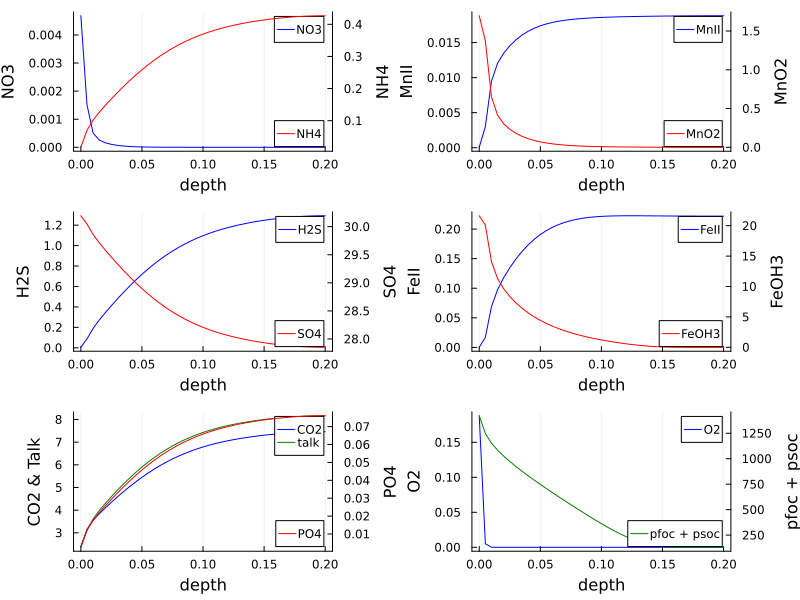

In [14]:
plot_OMdegradation(single_sol)

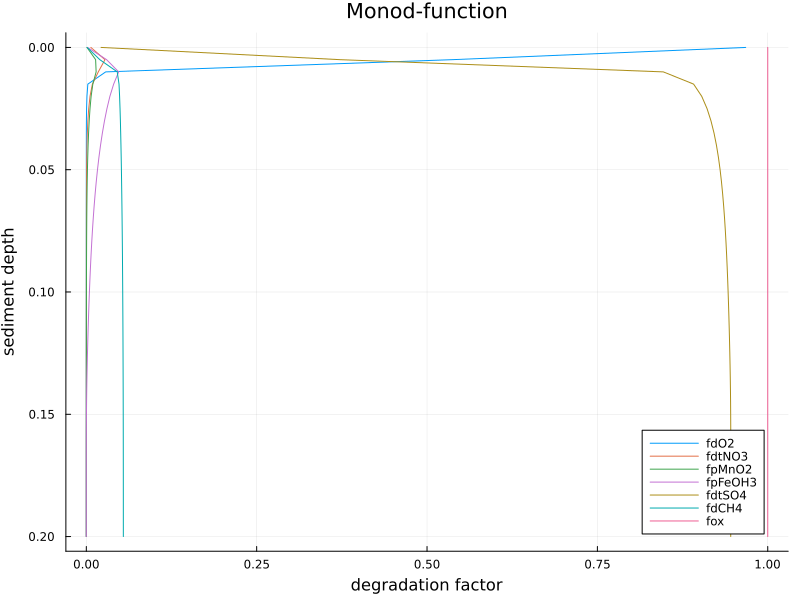

In [19]:
plot_monod(single_sol, 2)